# Real Data KKP

This notebook presents how to compute the fits for all real KKP data and produces the figures and table

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from fitle import (
    Param, INPUT, fit, Cost,
    gaussian, exponential, crystalball, convolve, identity
)
import mplhep
mplhep.style.use(mplhep.style.LHCb2)

## Setup

Import the required libraries. We use explicit imports from `fitle` for clarity and to access the modern Param builder syntax.

In [4]:
def plot_mass_spectrum(Dp_M, model_func, components, log=False):
    fig, ax = plt.subplots()
    x = np.linspace(1840, 2040, 5000)

    if log:
        plt.yscale('log')

    # histogram
    counts, edges = np.histogram(Dp_M, bins=200)
    plt.plot((edges[:-1] + edges[1:])/2, counts, label="Data")

    # main model
    plt.plot(x, model_func(x), label='Fit')

    # components
    for label, val in components.items():
        if isinstance(val, tuple):
            func, style = val
        else:
            func, style = val, {}
        plt.plot(x, func(x), label=label, **style)

    plt.ylabel('Entries per 1 MeV')
    plt.xlabel('$m(K K \pi)$         [MeV]')

    ymax = np.max(model_func(x)) * (2.5 if log else 1.05)
    plt.axis([1840, 2040, 40, ymax])

    plt.legend(bbox_to_anchor=[0.58, 0.5] if log else [0.69, 1])
    plt.text(
        0.05, 0.95, 'LHCb Preliminary',
        ha='left', va='top',
        transform=ax.transAxes,
        size=40
    )

    return fig, ax

In [5]:
Dp_M = np.load('../data/observed/kkp.npy')
Dp_M = Dp_M[Dp_M>1840]
Dp_M = Dp_M[Dp_M<2040]

First, we do a double gaussian fit

In [ ]:
# This function makes building models with interpretable N's easier
def model_sum(models, N=None, weights=None):
    if N is None:
        N = +Param
    elif np.isscalar(N):
        N = (+Param)(N)

    if weights is None:
        weights = [Param.unit('w') for _ in range(len(models) - 1)]

    weighted = [
        identity(weights[i] * models[i]) if i < len(models) - 1
        else identity(models[i] * (1 - sum(weights)))
        for i in range(len(models))
    ]

    return identity(N) * sum(weighted)

## Helper Function

The `model_sum` function creates a weighted sum of PDF components with a total normalization `N`. This allows us to fit both the relative fractions and the total yield simultaneously, making the fit results more physically interpretable.

In [ ]:
mu1 = Param('mu1')(1869)
mu2 = Param('mu2')(1970)

sigma1 = (+Param)(5)
sigma2 = (+Param)(10)
sigma3 = (+Param)(5)
sigma4 = (+Param)(10)

dp = model_sum([gaussian(mu1, sigma=sigma1), gaussian(mu1, sigma=sigma2)], 1e6)
ds = model_sum([gaussian(mu2, sigma=sigma3), gaussian(mu2, sigma=sigma4)], 1e6)
tail = (+Param('N_background'))(6e4) * exponential(tau=(+Param('tau'))(100), start=1860, end=2040)

model_gaussian = dp + ds + tail

In [ ]:
loss = model_gaussian | Cost.chi2(Dp_M, 200)

### Fit with Chi-squared Cost

We use a chi-squared cost function with 200 bins. This is appropriate for binned data with sufficient statistics per bin.

In [ ]:
fit(loss)

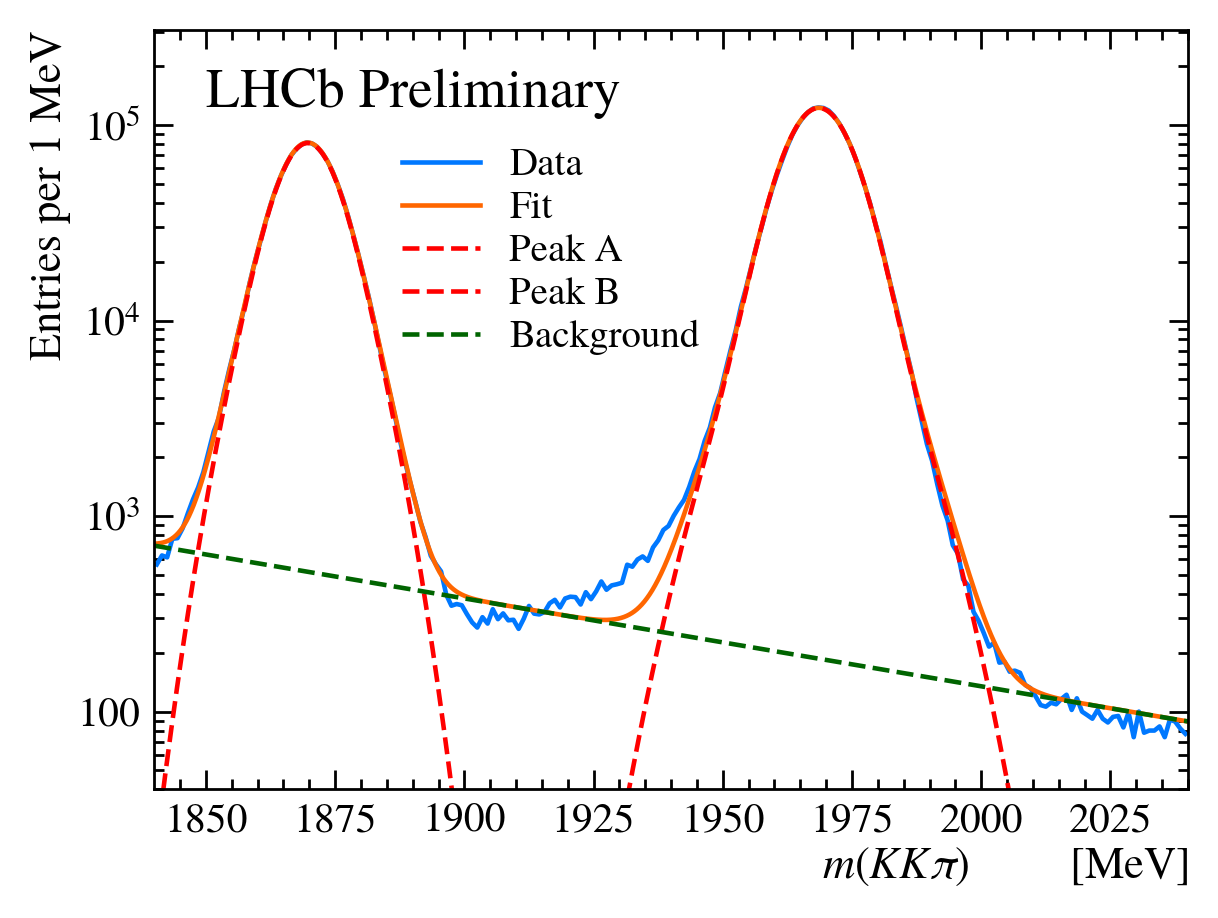

In [11]:
plot_mass_spectrum(Dp_M, model_gaussian, {
    "Peak A": (dp, {"color": "red", "linestyle": "--"}),
    "Peak B": (ds, {"color": "red", "linestyle": "--"}),
    "Background": (tail, {"color": "darkgreen", "linestyle": "--"})
}, log=True); plt.show()

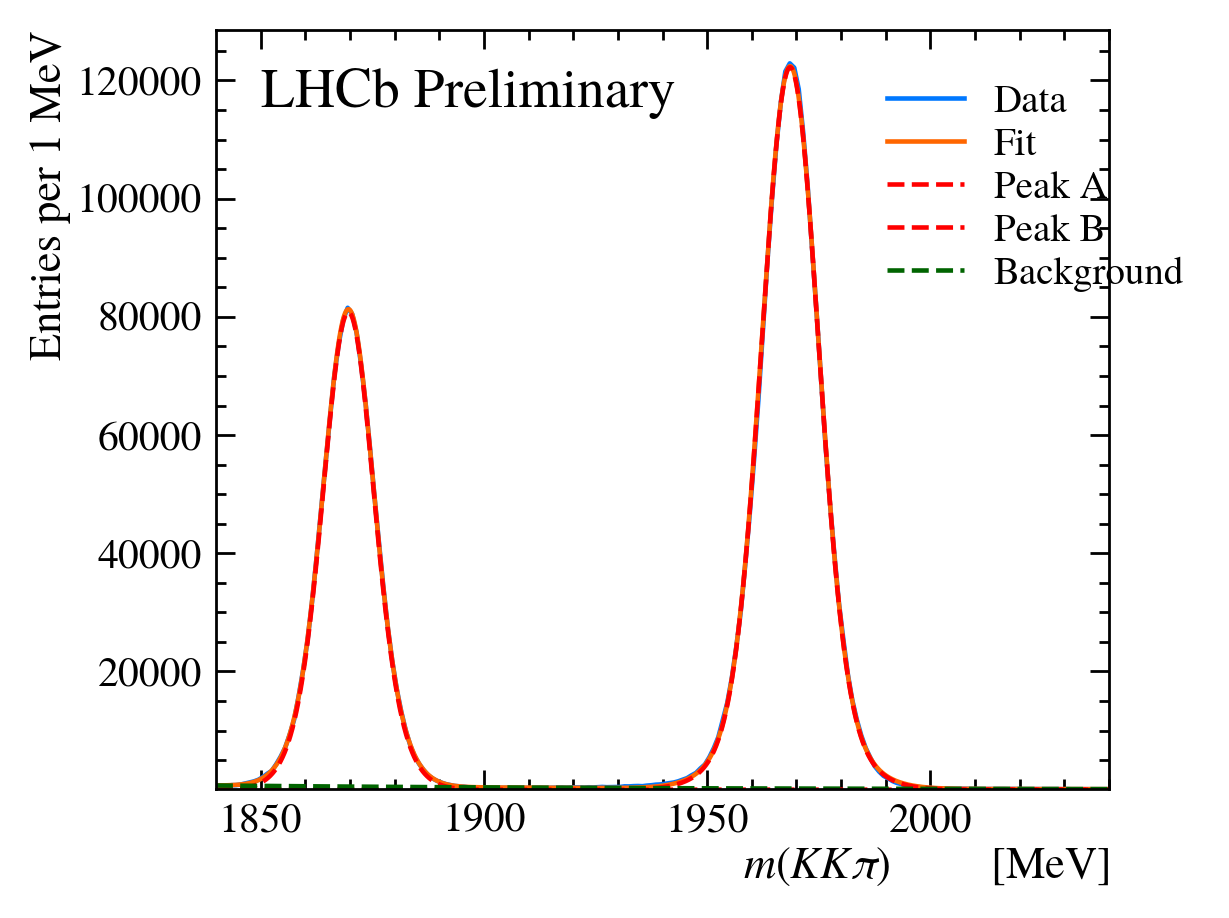

In [12]:
plot_mass_spectrum(Dp_M, model_gaussian, {
    "Peak A": (dp, {"color": "red", "linestyle": "--"}),
    "Peak B": (ds, {"color": "red", "linestyle": "--"}),
    "Background": (tail, {"color": "darkgreen", "linestyle": "--"})
}, log=False); plt.show()

In [13]:
Dp_x, Dp_c = np.load("../data/mc/histograms/Dp.npy")
Ds_x, Ds_c = np.load("../data/mc/histograms/Ds.npy")

Dp_mother_mass = 1869.65
Ds_mother_mass = 1968.33

## Convolution Models

The convolution approach uses Monte Carlo templates for the radiative tail shape (from PHOTOS simulation) convolved with a Gaussian resolution. This provides a more accurate description of the signal shape than simple analytical functions.

### Loading MC Templates

We load pre-computed histograms of the $D^+$ and $D_s^+$ mass distributions from PHOTOS simulation.

In [ ]:
# Bin width for 200 bins over [1840, 2040]
bin_width = (2040 - 1840) / 200  # = 1.0

conv1_mass2 = Param('mass')(1970)
conv1_mass1 = conv1_mass2 - Param('mass_diff')(100)

sigma1 = (+Param)(5)
sigma2 = (+Param)(10)
sigma3 = (+Param)(5)
sigma4 = (+Param)(10)

conv1_Dp = model_sum(
    [convolve(Dp_x, Dp_c, Dp_mother_mass, conv1_mass1, sigma1, bin_width=bin_width),
     convolve(Dp_x, Dp_c, Dp_mother_mass, conv1_mass1, sigma2, bin_width=bin_width)],
    5e5
)

conv1_Ds = model_sum(
    [convolve(Ds_x, Ds_c, Ds_mother_mass, conv1_mass2, sigma3, bin_width=bin_width),
     convolve(Ds_x, Ds_c, Ds_mother_mass, conv1_mass2, sigma4, bin_width=bin_width)],
    5e5
)

conv1_tail = (+Param('N_background'))(4e4) * exponential(tau=(+Param)(100), start=1840, end=2040)

conv1 = identity(conv1_Dp) + identity(conv1_Ds) + identity(conv1_tail)

### Double Gaussian Convolution (conv1)

Each signal peak is modeled as a sum of two convolutions with different Gaussian widths (double Gaussian resolution). This accounts for the non-Gaussian detector resolution. The background is modeled as a truncated exponential.

In [ ]:
fit_conv1 = fit(conv1 | Cost.chi2(Dp_M, 200))
fit_conv1

In [ ]:
fit_conv1 = fit(conv1 | Cost.chi2(Dp_M, 200))
fit_conv1

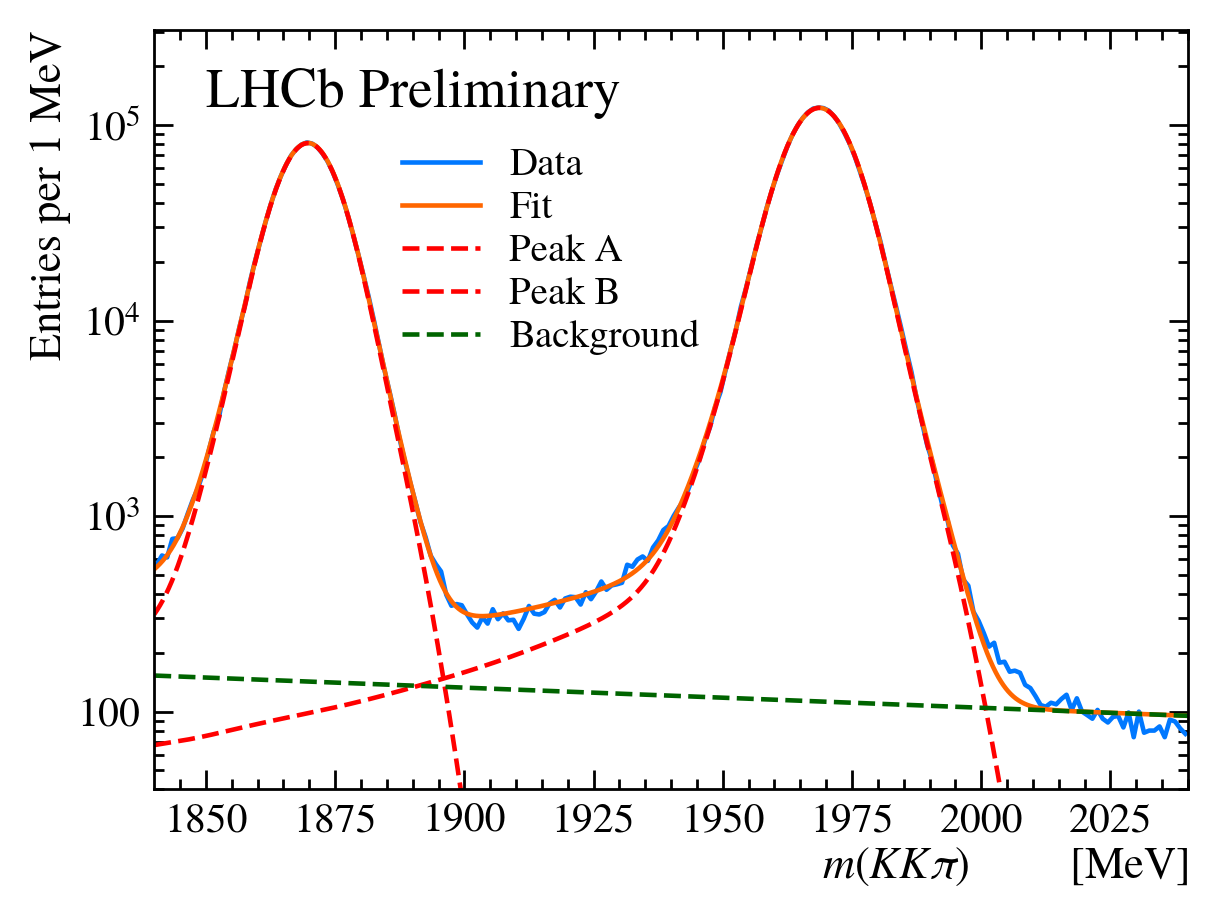

In [20]:
plot_mass_spectrum(Dp_M, conv1, {
    "Peak A": (conv1_Dp, {"color": "red", "linestyle": "--"}),
    "Peak B": (conv1_Ds, {"color": "red", "linestyle": "--"}),
    "Background": (conv1_tail, {"color": "darkgreen", "linestyle": "--"})
}, log=True); plt.show()

The following fit changes the tail for an exponential with varying degree.

In [ ]:
# Varying tau exponential - tau depends linearly on INPUT
tau_slope = Param('tau_slope')(-1)(-2, 0)
tau_intercept = Param('tau_intercept')(3000)(0, 6000)
varying_tau = tau_slope * INPUT + tau_intercept

conv2_tail = (
    (+Param('N_background'))(4e4)
    * exponential(tau=varying_tau, start=1840, end=2040)
)

conv2 = (conv1 % {conv1_tail: conv2_tail}).copy()

### Varying Tau Exponential (conv2)

This model extends conv1 by allowing the exponential decay constant to vary linearly with mass. This can better capture the shape of combinatorial background which may have mass-dependent characteristics.

In [ ]:
fit_conv2 = fit(conv2 | Cost.chi2(Dp_M, 200))
fit_conv2

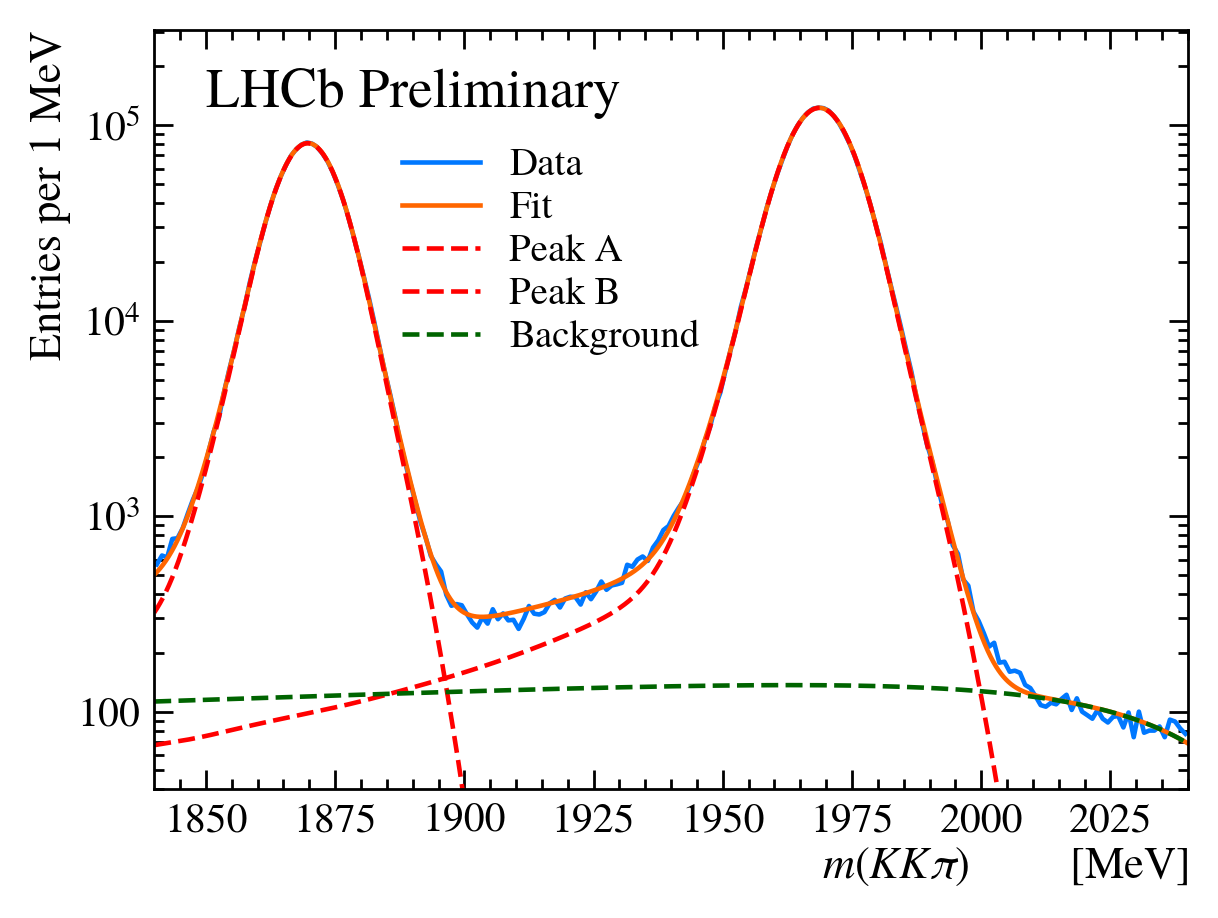

In [29]:
# problem with the copying approach is we lose the easilly interpretable "conv2_tail"
plot_mass_spectrum(Dp_M, conv2, {
    "Peak A": (conv2.components[0], {"color": "red", "linestyle": "--"}),
    "Peak B": (conv2.components[1], {"color": "red", "linestyle": "--"}),
    "Background": (conv2.components[2], {"color": "darkgreen", "linestyle": "--"})
}, log=True); plt.show()

The following model is like conv1, but it uses a triple gaussian convolution

In [ ]:
conv3_mass2 = Param('mass')(1970)
conv3_mass1 = conv3_mass2 - Param('mass_diff')(100)

conv3_sigma = (+Param('sigma'))(5)
conv3_Dp_part = convolve(Dp_x, Dp_c, Dp_mother_mass, conv3_mass1, conv3_sigma, bin_width=bin_width)
conv3_Ds_part = convolve(Ds_x, Ds_c, Ds_mother_mass, conv3_mass2, conv3_sigma, bin_width=bin_width)

conv3_Dp = model_sum(
    [conv3_Dp_part % {conv3_sigma: (conv3_sigma + 0).copy()} for i in range(3)],  # +0 is a temporary hack to turn param into model
    1e6
)

conv3_Ds = model_sum(
    [conv3_Ds_part % {conv3_sigma: (conv3_sigma + 0).copy()} for i in range(3)],
    1e6
)

conv3_tail = conv1_tail.copy()

conv3 = identity(conv3_Dp) + identity(conv3_Ds) + identity(conv3_tail)

### Triple Gaussian Convolution (conv3)

This model uses three Gaussian convolutions per peak instead of two, providing even more flexibility to describe the detector resolution function.

In [ ]:
fit_conv3 = fit(conv3 | Cost.chi2(Dp_M, 200))
fit_conv3

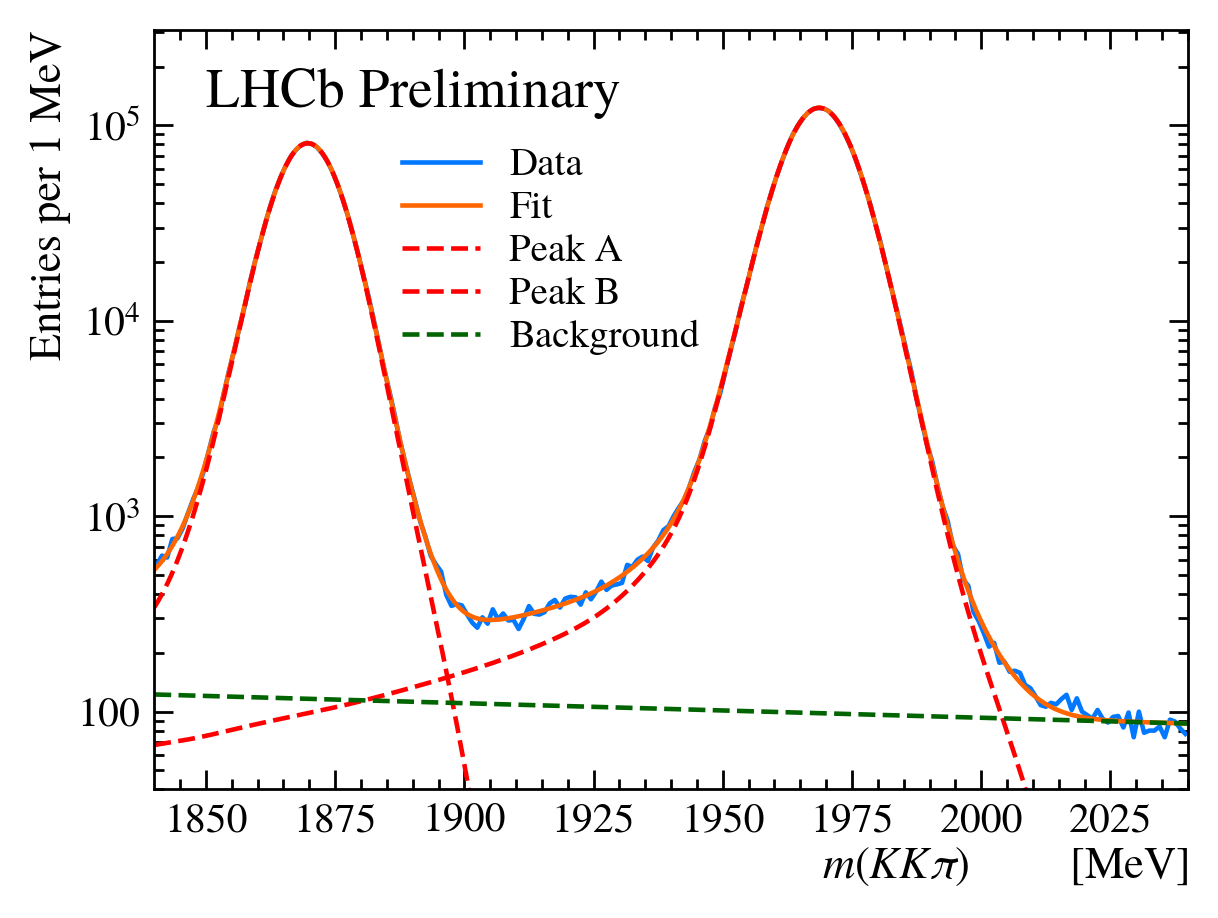

In [33]:
plot_mass_spectrum(Dp_M, conv3, {
    "Peak A": (conv3_Dp, {"color": "red", "linestyle": "--"}),
    "Peak B": (conv3_Ds, {"color": "red", "linestyle": "--"}),
    "Background": (conv3_tail, {"color": "darkgreen", "linestyle": "--"})
}, log=True); plt.show()

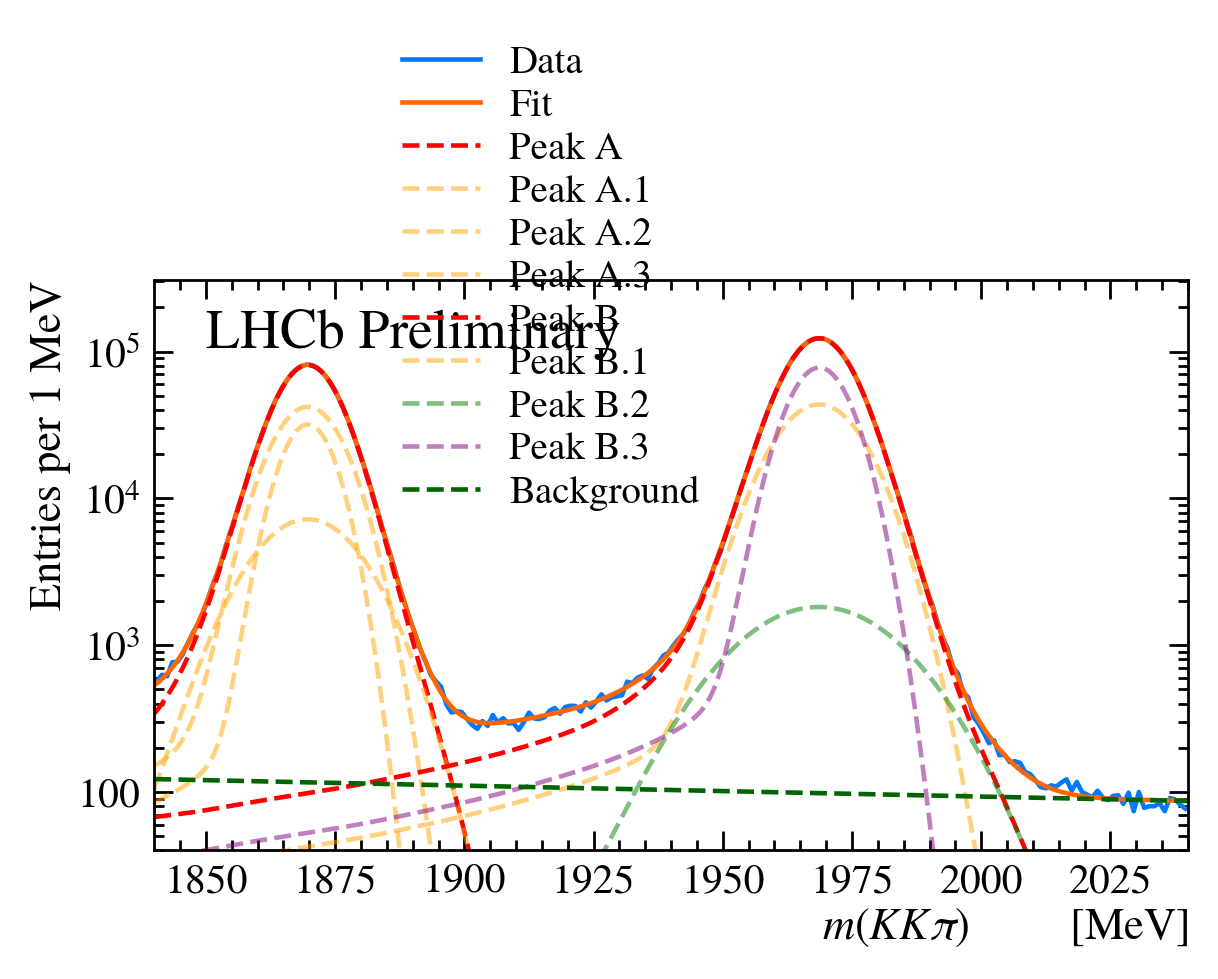

In [34]:
plot_mass_spectrum(Dp_M, conv3, {
    "Peak A": (conv3_Dp, {"color": "red", "linestyle": "--"}),
    "Peak A.1": (conv3_Dp.components[0] * conv3_Dp.components[1], {"color": "orange", "linestyle": "--", "alpha": 0.5}),
    "Peak A.2": (conv3_Dp.components[0] * conv3_Dp.components[2], {"color": "orange", "linestyle": "--", "alpha": 0.5}),
    "Peak A.3": (conv3_Dp.components[0] * conv3_Dp.components[3], {"color": "orange", "linestyle": "--", "alpha": 0.5}),
    
    "Peak B": (conv3_Ds, {"color": "red", "linestyle": "--"}),
    "Peak B.1": (conv3_Ds.components[0] * conv3_Ds.components[1], {"color": "orange", "linestyle": "--", "alpha": 0.5}),
    "Peak B.2": (conv3_Ds.components[0] * conv3_Ds.components[2], {"color": "green", "linestyle": "--", "alpha": 0.5}),
    "Peak B.3": (conv3_Ds.components[0] * conv3_Ds.components[3], {"color": "purple", "linestyle": "--", "alpha": 0.5}),
    
    "Background": (conv3_tail, {"color": "darkgreen", "linestyle": "--"})
}, log=True); plt.show()

In [35]:
conv4 = (conv3 % {conv3_tail : conv2_tail}).copy()
conv4_Dp = conv4.components[0]
conv4_Ds = conv4.components[1]
conv4_tail = conv4.components[2]

### Triple Gaussian with Varying Tau (conv4)

This model combines the triple Gaussian resolution from conv3 with the varying tau background from conv2, giving the most flexible parametrization.

In [ ]:
fit_conv4 = fit(conv4 | Cost.chi2(Dp_M, 200))
fit_conv4.minimizer

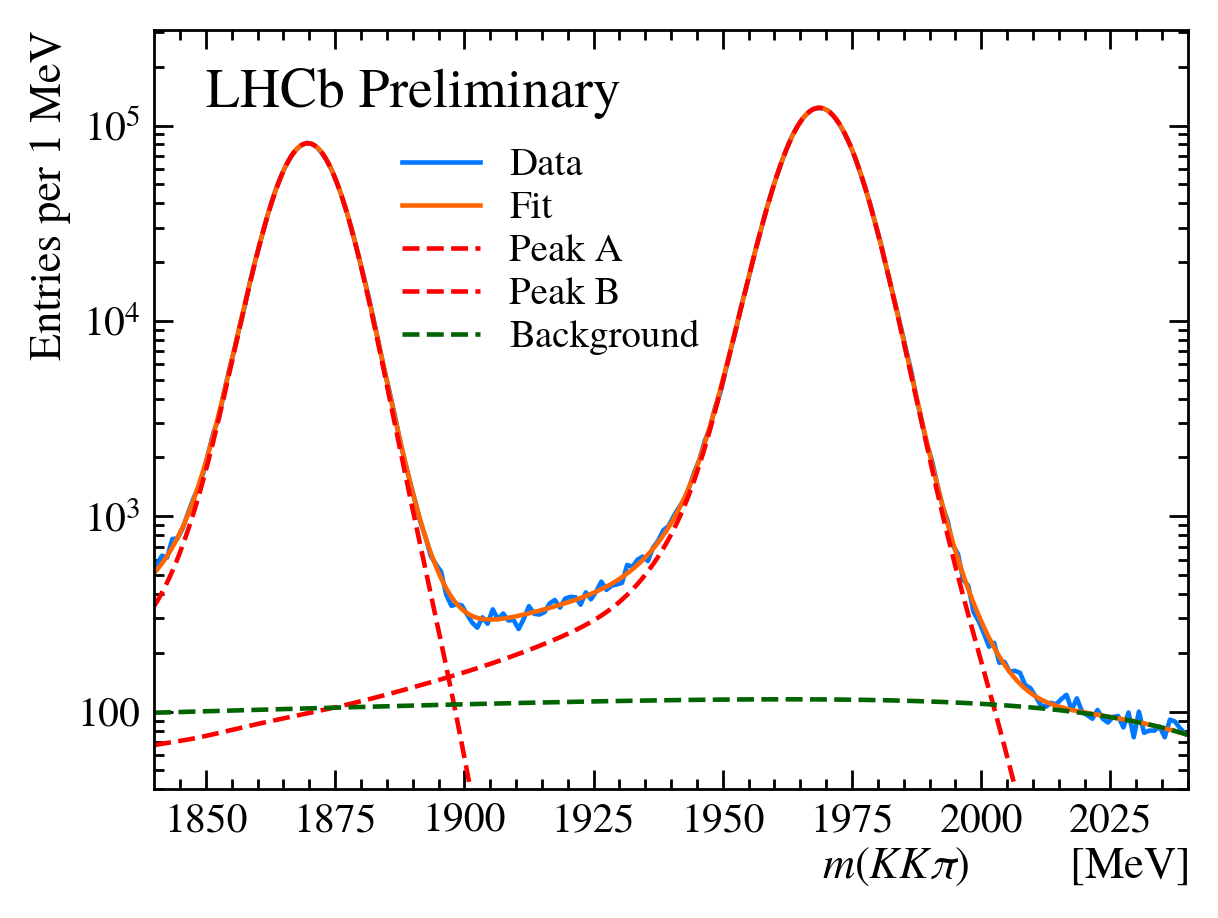

In [79]:
plot_mass_spectrum(Dp_M, conv4, {
    "Peak A": (conv4_Dp, {"color": "red", "linestyle": "--"}),
    "Peak B": (conv4_Ds, {"color": "red", "linestyle": "--"}),
    "Background": (conv4_tail, {"color": "darkgreen", "linestyle": "--"})
}, log=True); plt.show()

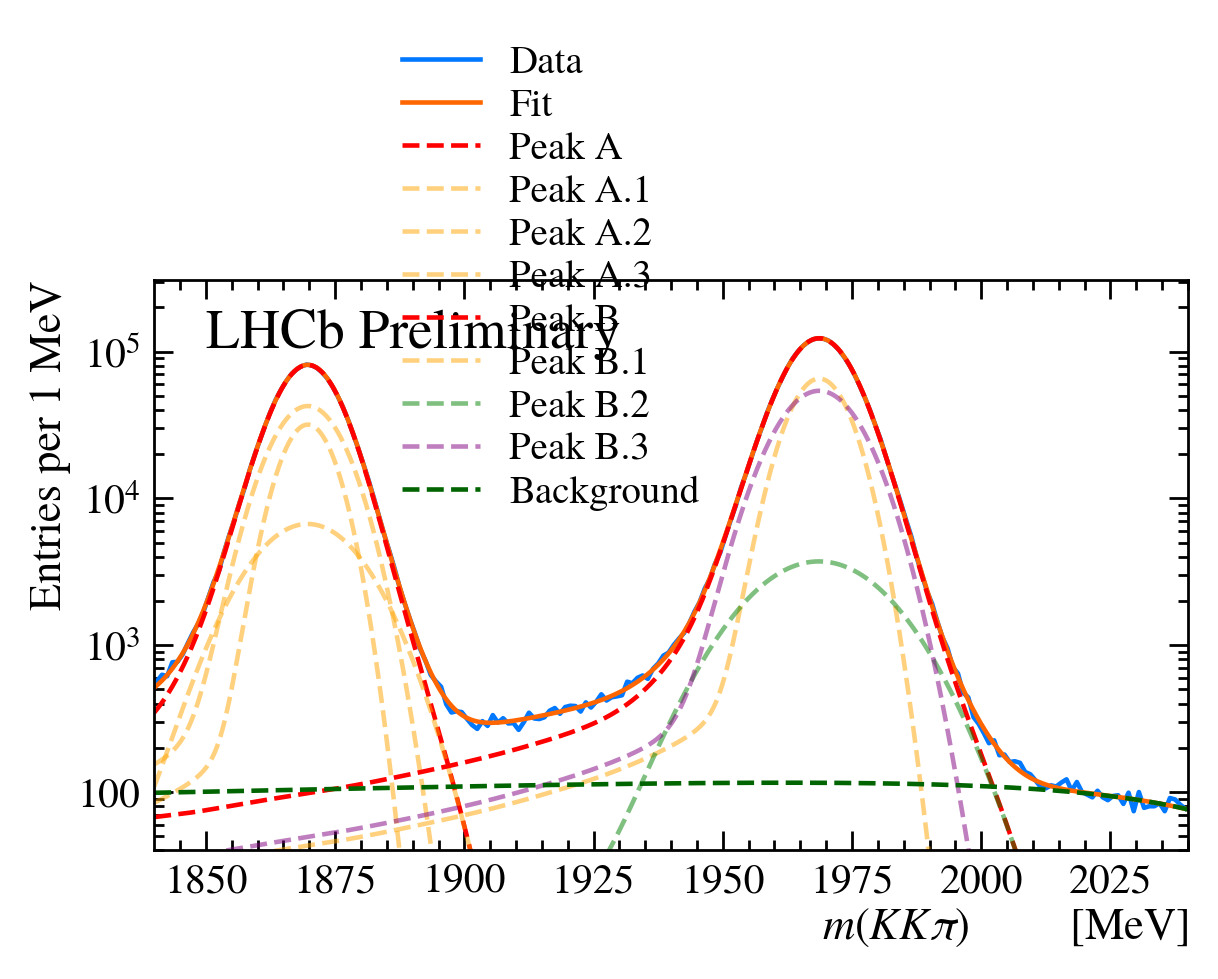

In [37]:
plot_mass_spectrum(Dp_M, conv4, {
    "Peak A": (conv4_Dp, {"color": "red", "linestyle": "--"}),
    "Peak A.1": (conv4_Dp.components[0] * conv4_Dp.components[1], {"color": "orange", "linestyle": "--", "alpha": 0.5}),
    "Peak A.2": (conv4_Dp.components[0] * conv4_Dp.components[2], {"color": "orange", "linestyle": "--", "alpha": 0.5}),
    "Peak A.3": (conv4_Dp.components[0] * conv4_Dp.components[3], {"color": "orange", "linestyle": "--", "alpha": 0.5}),
    
    "Peak B": (conv4_Ds, {"color": "red", "linestyle": "--"}),
    "Peak B.1": (conv4_Ds.components[0] * conv4_Ds.components[1], {"color": "orange", "linestyle": "--", "alpha": 0.5}),
    "Peak B.2": (conv4_Ds.components[0] * conv4_Ds.components[2], {"color": "green", "linestyle": "--", "alpha": 0.5}),
    "Peak B.3": (conv4_Ds.components[0] * conv4_Ds.components[3], {"color": "purple", "linestyle": "--", "alpha": 0.5}),
    
    "Background": (conv4_tail, {"color": "darkgreen", "linestyle": "--"})
}, log=True); plt.show()

In [ ]:
crys1_mass2 = Param('mass')(1970)
crys1_mass1 = crys1_mass2 - Param('mass_diff')(100)

crys1_alpha1 = Param('alpha1')(3.6)(0.5, 5)
crys1_n1_raw = Param('n_raw')(0.05)  # unconstrained
crys1_n1 = 1.0 + crys1_n1_raw**2     # ensures n >= 1

crys1_alpha2 = Param('alpha2')(1.8)(0.5, 5)
crys1_n2_raw = Param('n_raw')(0.05)  # unconstrained
crys1_n2 = 1.0 + crys1_n1_raw**2     # ensures n >= 1

s1 = (+Param('s1'))(5)
s2 = (+Param('s2'))(5)
s3 = (+Param('s3'))(5)
s4 = (+Param('s4'))(5)

crys1_Dp = model_sum(
    [
        crystalball(crys1_alpha1, crys1_n1, crys1_mass1, s1), 
        gaussian(crys1_mass1, s2)
    ], 1e6
)

crys1_Ds = model_sum(
    [
        crystalball(crys1_alpha2, crys1_n2, crys1_mass2, s3),
        gaussian(crys1_mass2, s4)
    ], 1e6
)

crys1_tail = (+Param)(40000) * exponential(tau=(+Param)(300), start=1840, end=2040)
crys1 = crys1_Dp + crys1_Ds + crys1_tail

## Crystal Ball Models

As an alternative to convolution, we can use analytical Crystal Ball functions which have a Gaussian core and a power-law tail. This is a common choice in particle physics for modeling detector effects.

### Crystal Ball + Gaussian (crys1)

Each peak is modeled as a sum of a Crystal Ball function and a Gaussian. The Crystal Ball captures the radiative tail while the additional Gaussian helps model the core resolution.

In [ ]:
fit_crys1 = fit(crys1 | Cost.chi2(Dp_M, 200), numba=False, grad=False)
fit_crys1

In [120]:
fit_crys1.minimizer

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 623.5                      │             Nfcn = 2021              │
│ EDM = 8.24e-06 (Goal: 0.0002)    │            time = 2.8 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │ 1.2331e6  │ 0.0012e6  │            │            │  1e-06  │         │       │
│ 1 │ x1   │   0.370   │   0.014   │            │            │    0    │    1    │       │
│ 2 │ x2   │1.968599e3 │0.000005e3 │            │            │         │         │       │
│ 3 │ x3   │  98.934   │   0.008   │            │            │         │         │       │
│ 4 │ x4   │   8.15    │   0.07    │            │            │  1e-06  │         │       │
│ 5 │ x5   │   3.778   │   0.014   │            │            │   0.5   │    5    │       │
│ 6 │ x6   │   2.22    │   0.11    │            │            │         │         │       │
│ 7 │ x7   │   5.304   │   0.031   │            │            │  1e-06  │         │       │
│ 8 │ x8   │ 2.0674e6  │ 0.0015e6  │            │            │  1e-06  │         │       │
│ 9 │ x9   │   0.300   │   0.009   │            │            │    0    │    1    │       │
│ 10│ x10  │   9.43    │   0.06    │            │            │  1e-06  │         │       │
│ 11│ x11  │   1.820   │   0.024   │            │            │   0.5   │    5    │       │
│ 12│ x12  │   5.959   │   0.021   │            │            │  1e-06  │         │       │
│ 13│ x13  │  59.7e3   │   0.7e3   │            │            │  1e-06  │         │       │
│ 14│ x14  │   105.3   │    1.7    │            │            │  1e-06  │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│     │          x0          x1          x2          x3          x4          x5          x6          x7          x8          x9         x10         x11         x12         x13         x14 │
├─────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│  x0 │    1.39e+06    -2.84450  -69.348e-3    48.37e-3      16.763   919.38e-3     -16.462      5.4822       0.1e6   372.61e-3      -1.859      1.9156   -866.4e-3      -0.2e6       444.3 │
│  x1 │    -2.84450    0.000197    0.001e-3          -0    -0.90e-3    -0.01e-3     0.27e-3    -0.42e-3  -416.46e-3          -0           0    -0.03e-3           0     2.85733    -7.59e-3 │
│  x2 │  -69.348e-3    0.001e-3    2.51e-05    0.026e-3   -0.004e-3    0.002e-3    0.050e-3   -0.001e-3 -112.515e-3    0.001e-3   -0.020e-3   -0.013e-3   -0.002e-3  112.224e-3   -0.136e-3 │
│  x3 │    48.37e-3          -0    0.026e-3     6.1e-05     0.02e-3           0     0.02e-3     0.01e-3  -155.81e-3           0    -0.03e-3    -0.01e-3          -0   -41.33e-3     0.80e-3 │
│  x4 │      16.763    -0.90e

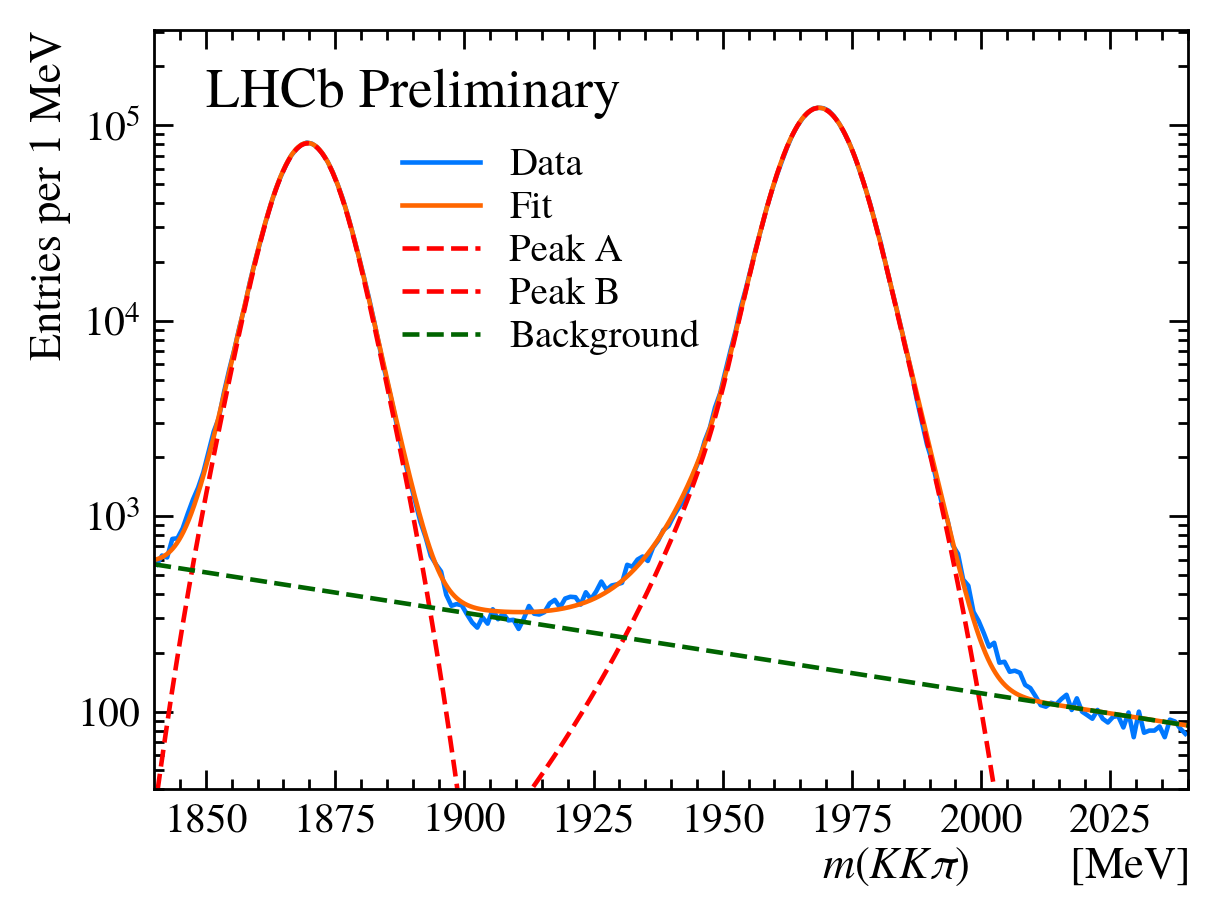

In [121]:
plot_mass_spectrum(Dp_M, crys1, {
    "Peak A": (crys1_Dp, {"color": "red", "linestyle": "--"}),
    "Peak B": (crys1_Ds, {"color": "red", "linestyle": "--"}),
    "Background": (crys1_tail, {"color": "darkgreen", "linestyle": "--"})
}, log=True); plt.show()

In [ ]:
crys2_mass2 = Param('mass')(1970)
crys2_mass1 = crys2_mass2 - Param('mass_diff')(100)

crys2_alpha1 = Param('alpha1')(3.6)(0.5, 5)
crys2_n1_raw = Param('n_raw')(0.05)  # unconstrained
crys2_n1 = 1.0 + crys2_n1_raw**2     # ensures n >= 1

crys2_alpha2 = Param('alpha2')(1.8)(0.5, 5)
crys2_n2_raw = Param('n_raw')(0.05)  # unconstrained
crys2_n2 = 1.0 + crys2_n1_raw**2     # ensures n >= 1

s1 = (+Param('s1'))(5)
s2 = (+Param('s2'))(5)
s3 = (+Param('s3'))(6)
s4 = (+Param('s4'))(5)
s5 = (+Param('s5'))(5)
s6 = (+Param('s6'))(5)

crys2_Dp = model_sum(
    [
        crystalball(crys2_alpha1, crys2_n1, crys2_mass1, s1), 
        gaussian(crys2_mass1, s2),
        gaussian(crys2_mass1, s3)
    ], 1e6
)

crys2_Ds = model_sum(
    [
        crystalball(crys2_alpha2, crys2_n2, crys2_mass2, s4),
        gaussian(crys2_mass2, s5),
        gaussian(crys2_mass2, s6),
    ], 1e6
)

crys2_tail = (+Param)(40000) * exponential(tau=(+Param)(300), start=1840, end=2040)
crys2 = crys2_Dp + crys2_Ds + crys2_tail

### Crystal Ball + Double Gaussian (crys2)

This extends crys1 by using a double Gaussian in addition to the Crystal Ball function for each peak, providing more flexibility in the core resolution modeling.

In [ ]:
fit_crys2 = fit(crys2 | Cost.chi2(Dp_M, 200), numba=False, grad=False)
fit_crys2

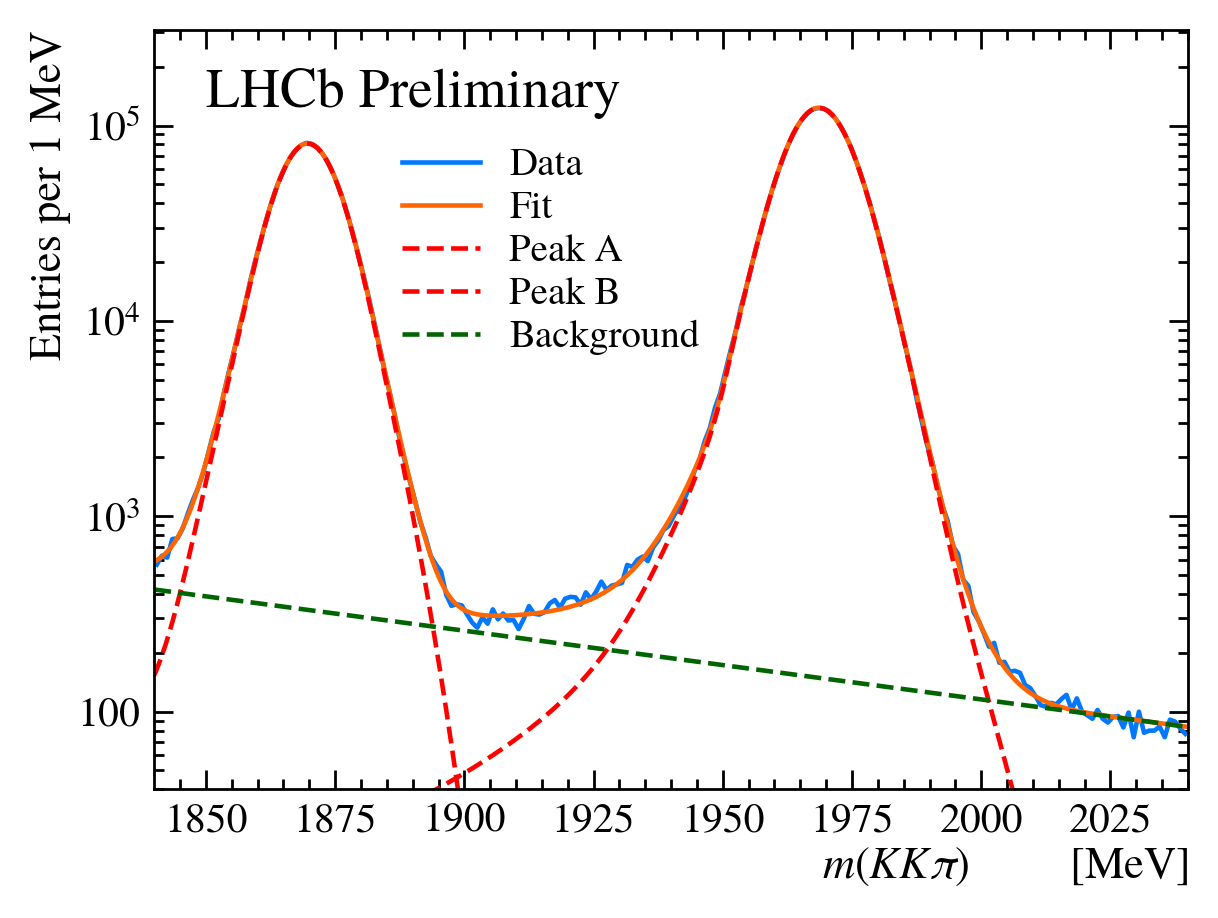

In [130]:
plot_mass_spectrum(Dp_M, crys2, {
    "Peak A": (crys2_Dp, {"color": "red", "linestyle": "--"}),
    "Peak B": (crys2_Ds, {"color": "red", "linestyle": "--"}),
    "Background": (crys2_tail, {"color": "darkgreen", "linestyle": "--"})
}, log=True); plt.show()

In [131]:
fits = [fit_conv1, fit_conv2, fit_conv3, fit_conv4, fit_crys1, fit_crys2]
for fit in fits:
    print(f" & {len(fit.values)} & {fit.values['mass']:.3f} ± {fit.errors['mass']:.3f} & {fit.values['mass_diff']:.3f} ± {fit.errors['mass_diff']:.3f} & {fit.fval/(200 - len(fit.values)):.1f} \\\\")

 & 12 & 1968.699 ± 0.005 & 98.938 ± 0.008 & 2.8 \\
 & 13 & 1968.698 ± 0.005 & 98.940 ± 0.008 & 2.4 \\
 & 16 & 1968.699 ± 0.005 & 98.938 ± 0.008 & 1.4 \\
 & 17 & 1968.698 ± 0.005 & 98.940 ± 0.008 & 1.3 \\
 & 15 & 1968.599 ± 0.005 & 98.934 ± 0.008 & 3.4 \\
 & 19 & 1968.600 ± 0.005 & 98.915 ± 0.009 & 2.0 \\


## Results Summary

Compare all fit models. The key parameters are:
- **mass**: The $D_s^+$ mass
- **mass_diff**: The mass difference $m(D_s^+) - m(D^+)$
- **$\chi^2$/ndf**: Fit quality metric (lower is better)